In [1]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import inv

In [2]:
df=pd.read_csv('sts_data.csv')
df.head()

,T1,T2,T3,T4,T5,T6,d',D,TK,Vs,...,lo,x mtr,y mtrs,xinCM,yinCM,Y fc,Mes_x,Mes_y,Xd,Yd
0,0.0,0.000287,0.000770,0.000692,0.001025,0.000998,0.25,0.63,39.55068,354.701017,...,0.564584,0.007040,0.564540,0.703987,56.454010,-2.445990,-1.8,-1.7,-1.503987,0.745990
1,0.0,0.000281,0.000839,0.000585,0.001089,0.000885,0.25,0.63,39.06240,354.423844,...,0.588193,0.053865,0.585721,5.386534,58.572137,-0.327863,3.0,0.7,-1.386534,1.027863
2,0.0,0.000282,0.000810,0.000705,0.001059,0.001009,0.25,0.63,39.06240,354.423844,...,0.536937,0.012700,0.536787,1.270044,53.678677,-5.221323,-1.5,-4.6,-1.770044,0.621323
3,0.0,0.000278,0.000843,0.000636,0.001089,0.000934,0.25,0.63,39.06240,354.423844,...,0.558559,0.039917,0.557131,3.991681,55.713130,-3.186870,1.8,-3.0,-1.191681,0.186870
4,0.0,0.000281,0.000872,0.000597,0.001130,0.000899,0.25,0.63,39.55068,354.701017,...,0.554155,0.059410,0.550961,5.940989,55.096106,-3.803894,3.9,-2.2,-1.040989,1.603894


In [3]:
df.T2*=1000
df.T3*=1000
df.T4*=1000
df.T5*=1000
df.T6*=1000
df.Vs/=1000
df.head()

,T1,T2,T3,T4,T5,T6,d',D,TK,Vs,...,lo,x mtr,y mtrs,xinCM,yinCM,Y fc,Mes_x,Mes_y,Xd,Yd
0,0.0,0.287,0.770,0.692,1.025,0.998,0.25,0.63,39.55068,0.354701,...,0.564584,0.007040,0.564540,0.703987,56.454010,-2.445990,-1.8,-1.7,-1.503987,0.745990
1,0.0,0.281,0.839,0.585,1.089,0.885,0.25,0.63,39.06240,0.354424,...,0.588193,0.053865,0.585721,5.386534,58.572137,-0.327863,3.0,0.7,-1.386534,1.027863
2,0.0,0.282,0.810,0.705,1.059,1.009,0.25,0.63,39.06240,0.354424,...,0.536937,0.012700,0.536787,1.270044,53.678677,-5.221323,-1.5,-4.6,-1.770044,0.621323
3,0.0,0.278,0.843,0.636,1.089,0.934,0.25,0.63,39.06240,0.354424,...,0.558559,0.039917,0.557131,3.991681,55.713130,-3.186870,1.8,-3.0,-1.191681,0.186870
4,0.0,0.281,0.872,0.597,1.130,0.899,0.25,0.63,39.55068,0.354701,...,0.554155,0.059410,0.550961,5.940989,55.096106,-3.803894,3.9,-2.2,-1.040989,1.603894


# ITERATIVE ALGORITHM

In [4]:
def fun(X,c):
    x,h,V,alpha,t_offset = list(X)
    #T1,T2,T3,T4,T5,T6 x and y co-ordinate
    x0 = [0.0,0.0,0.63,-0.63,0.63]
    y0 = [0.0,0.25,0.0,0.25,0.25]
    T=[]
    for j in range(len(x0)):
        x_k,y_k = x0[j],y0[j]
        t_i = t_offset -((1/V)*((x-x_k)*math.sin(alpha)-y_k*math.cos(alpha)))\
            +((((x-x_k)*math.cos(alpha)+y_k*math.sin(alpha))**2+h**2)**0.5)*((1/c**2)-(1/V**2))**0.5
        T.append(t_i)
    return np.asarray(T,dtype='float')

In [5]:
def derivative_matrix(X,c):
    x,h,V,alpha,t_offset = list(X)
    #T1,T2,T3,T4,T5,T6 x and y co-ordinate
    x0 = [0.0,0.0,0.63,-0.63,0.63]
    y0 = [0.0,0.25,0.0,0.25,0.25]
    derivate=[]
    for j in range(len(x0)):
        x_k,y_k = x0[j],y0[j]
        Q = ((((x-x_k)*math.cos(alpha)+y_k*math.sin(alpha))**2+h**2)**0.5)
        dt_dx = -(math.sin(alpha)/V) + ((1/Q)*((1/c**2)-(1/V**2))**0.5)\
            *((x-x_k)*math.cos(alpha)+y_k*math.sin(alpha))*math.cos(alpha)
        dt_dh = (h/Q)*((1/c**2)-(1/V**2))**0.5
        dt_dV = (1/V**2)*((x-x_k)*math.sin(alpha)-y_k*math.cos(alpha))+(Q/(V**3*((1/c**2)-(1/V**2))**0.5))
        #dt_dc = -(Q/(c**3*((1/c**2)-(1/V**2))**0.5))
        dt_dalpha = -((x-x_k)*math.cos(alpha)+y_k*math.sin(alpha))\
                *((1/V)+(1/Q)*(((1/c**2)-(1/V**2))**0.5)*((x-x_k)*math.sin(alpha)-y_k*math.cos(alpha)))
        dt_dt_offset = 1
        derivate.append([dt_dx,dt_dh,dt_dV,dt_dalpha,dt_dt_offset])
    return np.asarray(derivate,dtype='float')

In [6]:
def iterative_nonliner_solver(i):
    x_old_log=[]
    x_new_log=[]
    for j in range(100):
        if j==0:
            #x,h,V,c,alpha,t_offset = []
            X_guess = np.array([0.01,0.2,0.6,0.0,0.0],dtype='float')
            X_old = X_guess
            #print(f'X_old:{X_old}')
        #print(f'X_old:{X_old}')
        x_old_log.append(X_old)
        #i=0
        M_calculated=fun(X_old,df.Vs[i])
        M_calculated=M_calculated.reshape(1,5)
        #print(f'M_calculated:{M_calculated}')
        M_measured = np.asarray([df.T1[i],df.T2[i],df.T4[i],df.T5[i],df.T6[i]],dtype='float')
        M_measured =M_measured.reshape(1,5)
        #print("M_measured:",M_measured)
        H =derivative_matrix(X_old,df.Vs[i])
        #print(np.matmul(np.matmul(inv(np.matmul(H.T,H)),H.T),(M_measured.T-M_calculated.T)))
        X_new = X_old.reshape(1,5).T+np.matmul(np.matmul(inv(np.matmul(H.T,H)),H.T),(M_measured.T-M_calculated.T))
        #X_new=np.array([X_new[0][0],X_new[1][0],X_new[2][0],X_new[3][0],X_new[4][0],X_new[5][0]])
        X_old= X_new.reshape(1,5)[0]
        #print("X_new:",X_old)
        x_new_log.append(X_old)
        #print("Residual vector after each iteration:",M_measured-M_calculated)
        if j>=1:
            if(np.all(np.isclose(x_old_log[j-1],x_old_log[j]))):
                return X_old,H
                break

            #if(np.array_equal(x_old_log[j-1],x_old_log[j])):
                #break
        print("\n#########################################    "+str(j)+"   *******************************************\n")

In [7]:
with open("result_compare.txt","w+")as f:
    f.write("their_x,our_x,their_y,our_y,correct_x,correct_y,their_v,our_v,alpha\n")
    for i in range(0,35):
        X_old,_=iterative_nonliner_solver(i)
        result_str=str(df.xinCM[i])+","+str(X_old[0]*100)+","+str(df.yinCM[i])+","+str(X_old[1]*100)+","+str(df.Mes_x[i])+","+str(df.Mes_y[i])+","+str(df["d'"][i]/df.T2[i]*1000)+","+str(X_old[2]*1000)+","+str(X_old[3])+"\n"
        print(f"i:{i},X:{X_old}")
        f.write(result_str)


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:0,X:[ 0.00197886  0.56334245  0.87080349 -0.03982168 -1.4505913 ]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   ***************************

In [8]:
df_m=pd.read_csv('result_compare.txt')
df_m.head()

,their_x,our_x,their_y,our_y,correct_x,correct_y,their_v,our_v,alpha
0,0.703987,0.197886,56.454010,56.334245,-1.8,-1.7,871.080139,870.803491,-0.039822
1,5.386534,4.919620,58.572137,58.592959,3.0,0.7,889.679715,883.274150,-0.037602
2,1.270044,0.774459,53.678677,53.550156,-1.5,-4.6,886.524823,885.279534,-0.044532
3,3.991681,3.553833,55.713130,55.691195,1.8,-3.0,899.280576,894.104278,-0.039244
4,5.940989,5.484117,55.096106,55.129373,3.9,-2.2,889.679715,881.691928,-0.039962


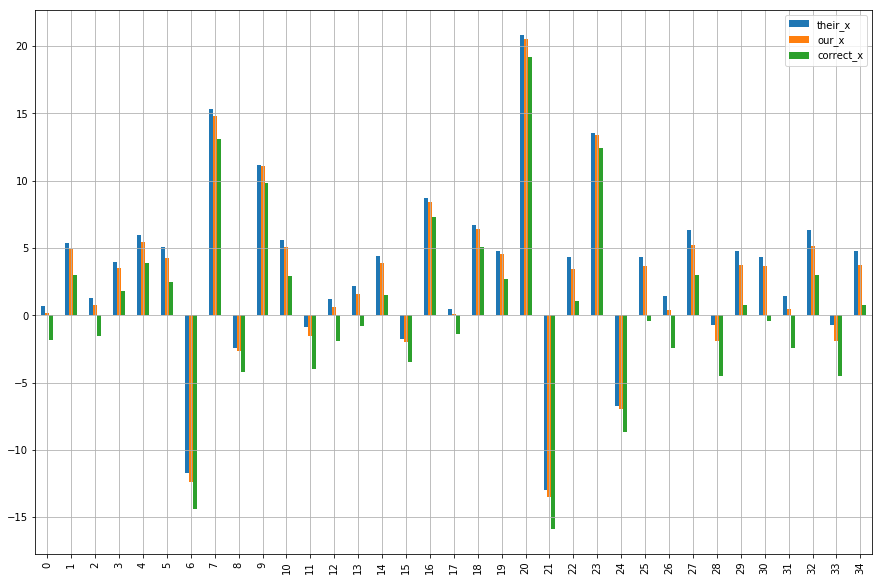

In [26]:
df_m.plot(y=['their_x','our_x','correct_x'],figsize=(15,10),grid=True,kind='bar')

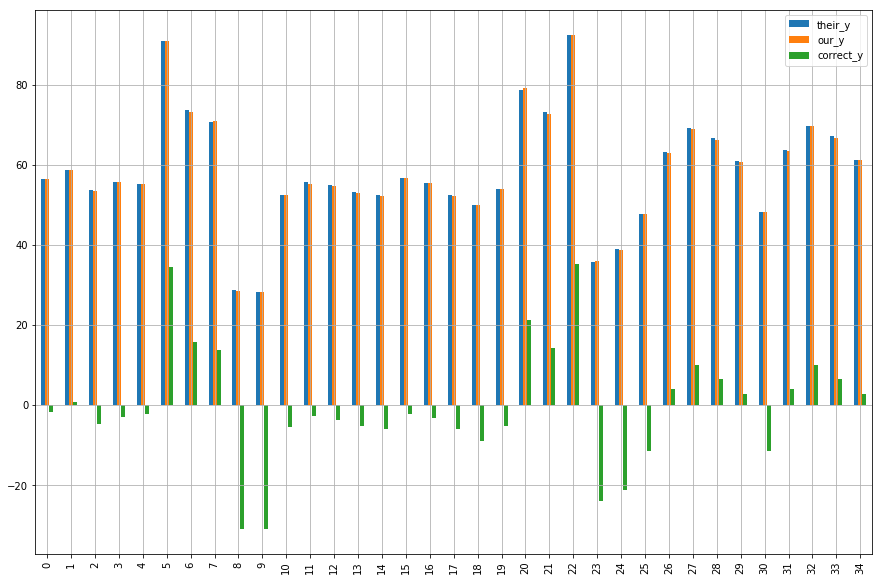

In [27]:
df_m.plot(y=['their_y','our_y','correct_y'],figsize=(15,10),grid=True,kind='bar')

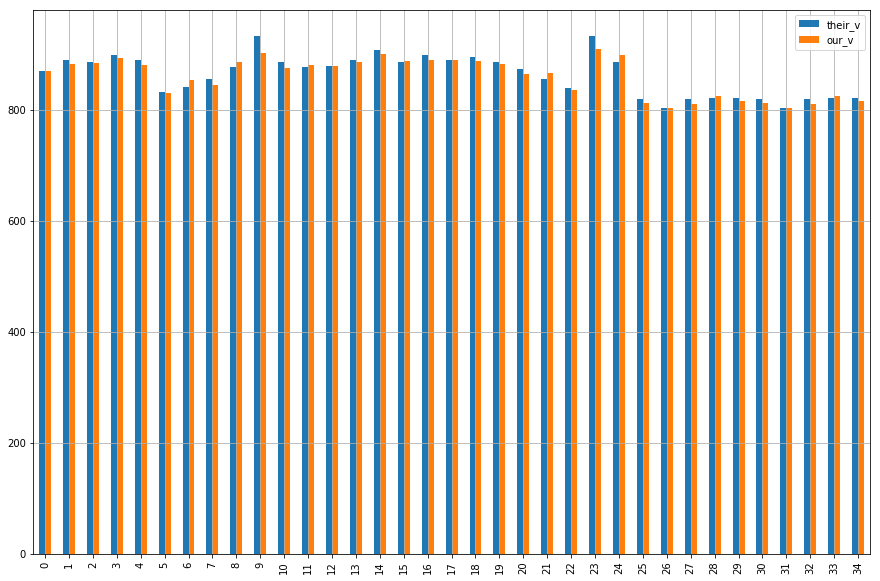

In [28]:
df_m.plot(y=['their_v','our_v'],figsize=(15,10),grid=True,kind='bar')

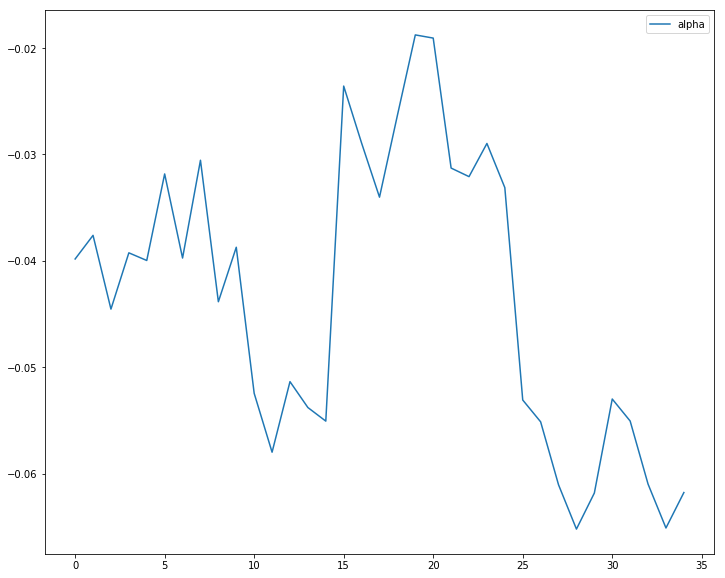

In [13]:
df_m.plot(y=['alpha'],figsize=(12,10))

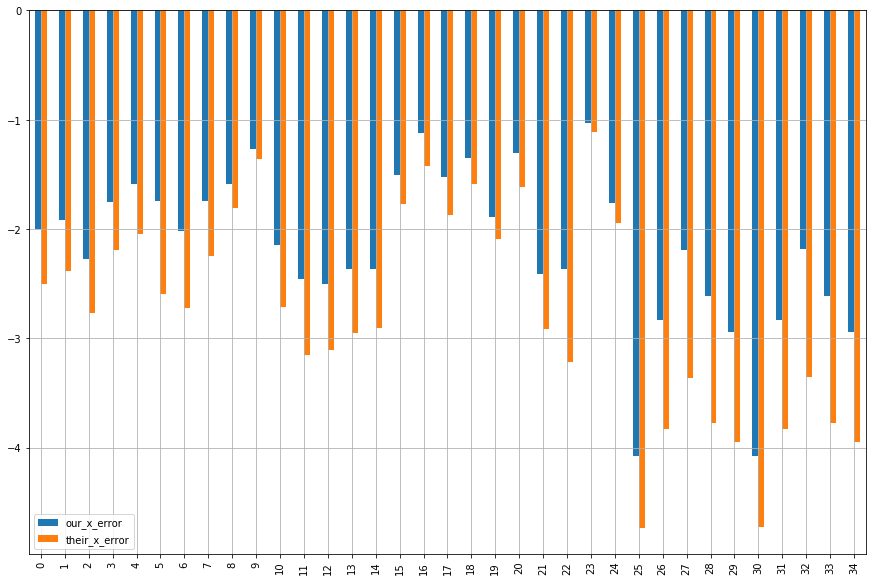

In [29]:
df_m['our_x_error']=df_m.correct_x-df_m.our_x
df_m['their_x_error']=df_m.correct_x-df_m.their_x
df_m.plot(y=['our_x_error','their_x_error'],figsize=(15,10),grid=True,kind='bar')

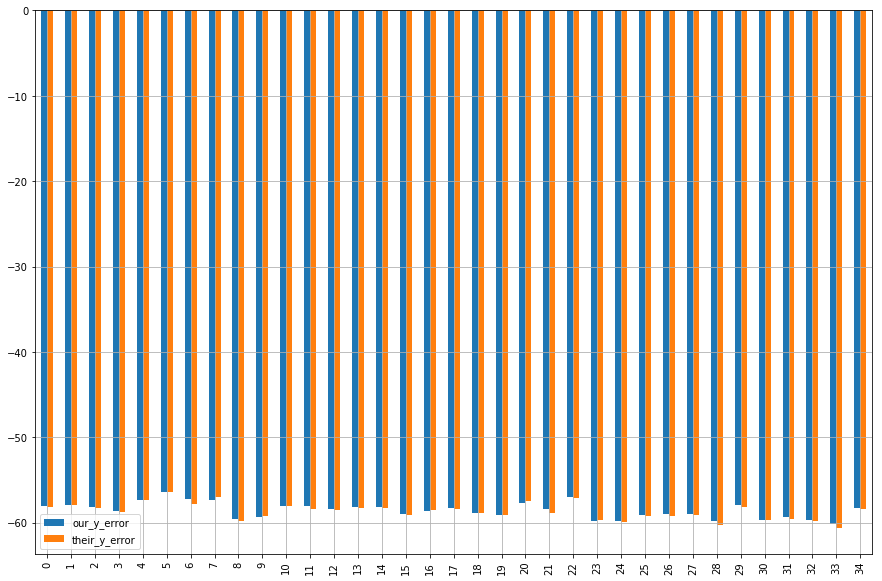

In [30]:
df_m['our_y_error']=df_m.correct_y-df_m.our_y
df_m['their_y_error']=df_m.correct_y-df_m.their_y
df_m.plot(y=['our_y_error','their_y_error'],figsize=(15,10),grid=True,kind='bar')

In [16]:
print("our_x_error mean:",abs(np.mean(df_m.our_x_error)))
print("their_x_error mean:",abs(np.mean(df_m.their_x_error)))
print("\n")
print("our_y_error mean:",abs(np.mean(df_m.our_y_error)))
print("their_y_error mean:",abs(np.mean(df_m.their_y_error)))
print("\n")
x_per=(abs(np.mean(df_m.their_x_error))-abs(np.mean(df_m.our_x_error)))/abs(np.mean(df_m.their_x_error))
x_per*=100
print("x_error_improvement mean %:",x_per)
print("\n")
y_per=(abs(np.mean(df_m.their_y_error))-abs(np.mean(df_m.our_y_error)))/abs(np.mean(df_m.their_y_error))
y_per*=100
print("y_error_improvement mean %:",y_per)

our_x_error mean: 2.1506980797999242
their_x_error mean: 2.750705384571428


our_y_error mean: 58.56166203563092
their_y_error mean: 58.65759476742856


x_error_improvement mean %: 21.8128523736826


y_error_improvement mean %: 0.16354699195902855


# EXPECTED RANDOM ERROR

In [17]:
with open("expected_random_error.txt",'w+')as f1:
    f1.write("sigma_x,sigma_y,sigma_p,sigma_alpha,sigma_v\n")
    for i in range(0,35):
        X_old,H=iterative_nonliner_solver(i)
        #result_str=str(df.xinCM[i])+","+str(X_old[0]*100)+","+str(df.yinCM[i])+","+str(X_old[1]*100)+","+str(df.Mes_x[i])+","+str(df.Mes_y[i])+","+str(df["d'"][i]/df.T2[i]*1000)+","+str(X_old[2]*1000)+","+str(X_old[3])+"\n"
        #print(f"i:{i},X:{X_old}")
        #print(f"H:{H}")
        print(inv(np.matmul(H.T,H)))
        sigma_t = 10*10**-6
        # the total hit position error
        sigma_x = sigma_t *(inv(np.matmul(H.T,H))[0][0]) **0.5
        sigma_h = sigma_t *(inv(np.matmul(H.T,H))[1][1]) **0.5
        sigma_p = sigma_t*(inv(np.matmul(H.T,H))[0][0]+inv(np.matmul(H.T,H))[1][1])**0.5
        #the incidence-angle error
        sigma_alpha =sigma_t * (inv(np.matmul(H.T,H))[3][3])**0.5
        #the velocity error
        sigma_v = sigma_t * (inv(np.matmul(H.T,H))[2][2]) **0.5
        sigma_str=str(sigma_x)+","+str(sigma_h)+","+str(sigma_p)+","+str(sigma_alpha)+","+str(sigma_v)+"\n"
        f1.write(sigma_str)
    #     print(sigma_str)
    #     print(f"sigma_x:{sigma_x}")
    #     print(f"sigma_h:{sigma_h}")
    #     print(f"sigma_p:{sigma_p}")
    #     print(f"sigma_alpha:{sigma_alpha}")
    #     print(f"sigma_v:{sigma_v}")


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

[[  0.50757305   0.31080553  -1.31360135   2.57529947  -0.60087747]
 [  0.31080553   1.59129374  -0.84167158   2.35585847  -3.38239294]
 [ -1.31360135  -0.84167158  18.60861721 -12.97096989  -0.90408048]
 [  2.57529947   2.35585847 -12.97096989  17.87606286  -3.98661685]
 [ -0.60087747  -3.38239294  -0.90408048  -3.98661685   7.876044  ]]

#########################################    0   *******************************************


#########################################    1   ***************************************

In [18]:
df_e=pd.read_csv("expected_random_error.txt")
df_e.head()

,sigma_x,sigma_y,sigma_p,sigma_alpha,sigma_v
0,0.000007,0.000013,0.000014,0.000042,0.000043
1,0.000007,0.000013,0.000014,0.000040,0.000040
2,0.000006,0.000012,0.000014,0.000041,0.000044
3,0.000007,0.000012,0.000014,0.000040,0.000042
4,0.000007,0.000012,0.000013,0.000038,0.000039


In [19]:
df_e*=10**5

In [20]:
df_e.head()

,sigma_x,sigma_y,sigma_p,sigma_alpha,sigma_v
0,0.712442,1.261465,1.448747,4.228009,4.313771
1,0.721909,1.255154,1.447952,3.986682,3.998753
2,0.637152,1.192697,1.352216,4.087595,4.401065
3,0.655936,1.196047,1.364105,3.955175,4.208328
4,0.668638,1.172250,1.349536,3.838055,3.931496


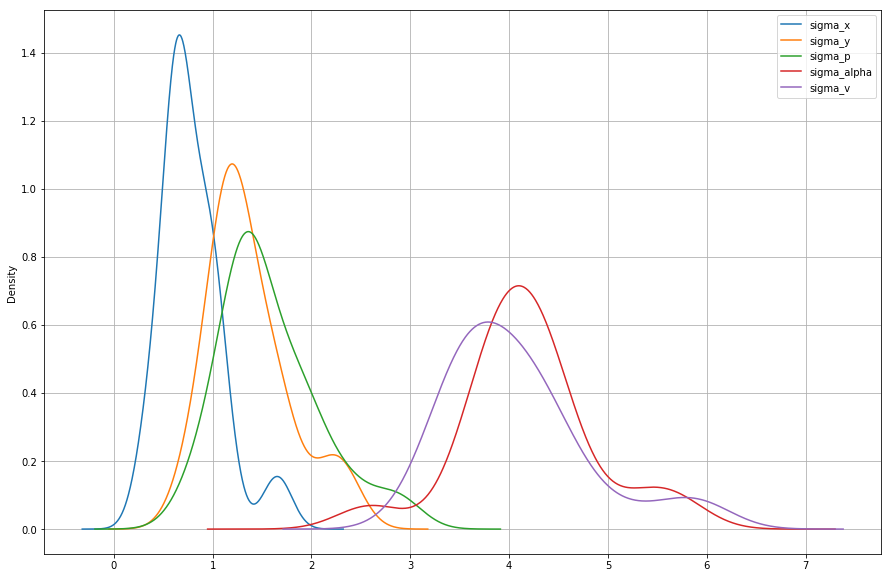

In [31]:
df_e.plot(y=['sigma_x','sigma_y','sigma_p','sigma_alpha','sigma_v'],grid=True,kind='density',figsize=(15,10))